## 03_CNN.ipynb

In [3]:
import zipfile

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

## 데이터 분석을 하든 머신러닝을 하든 아주 중요한 첫 단계는 데이터와 하나가 되는 것,
## 즉, 데이터를 살펴보고 알아보는 것 => 시각화 이용할 수도 있고, 간단한 통계량을 활용 수도 있습니다.

In [4]:
import os

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
    print(f"{dirpath}에는 {len(dirnames)}개의 디렉토리와 {len(filenames)}개의 파일이 존재합니다.")

pizza_steak에는 2개의 디렉토리와 1개의 파일이 존재합니다.
pizza_steak\test에는 2개의 디렉토리와 1개의 파일이 존재합니다.
pizza_steak\test\pizza에는 0개의 디렉토리와 250개의 파일이 존재합니다.
pizza_steak\test\steak에는 0개의 디렉토리와 250개의 파일이 존재합니다.
pizza_steak\train에는 2개의 디렉토리와 1개의 파일이 존재합니다.
pizza_steak\train\pizza에는 0개의 디렉토리와 750개의 파일이 존재합니다.
pizza_steak\train\steak에는 0개의 디렉토리와 750개의 파일이 존재합니다.


In [5]:
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

In [8]:
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/")
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['pizza' 'steak']


## pizza 및 steak는 모두 750장의 학습 데이터와 250장의 테스트 데이터가 존재합니다.

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)

    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}")

    return img

Image shape: (512, 384, 3)


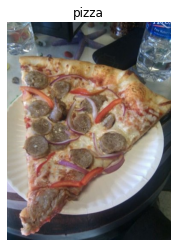

In [35]:
img = view_random_image(target_dir = "pizza_steak/train/", target_class = "pizza")

In [36]:
img

array([[[134, 128, 132],
        [147, 141, 145],
        [157, 152, 156],
        ...,
        [ 62,  82, 141],
        [153, 172, 228],
        [108, 128, 181]],

       [[149, 144, 148],
        [159, 154, 158],
        [165, 160, 164],
        ...,
        [125, 146, 203],
        [150, 170, 223],
        [ 56,  76, 126]],

       [[145, 143, 146],
        [149, 149, 151],
        [152, 152, 154],
        ...,
        [158, 180, 230],
        [109, 131, 178],
        [ 15,  38,  80]],

       ...,

       [[ 20,  35,  54],
        [ 19,  34,  53],
        [ 18,  33,  52],
        ...,
        [ 17,  21,  22],
        [ 17,  21,  22],
        [ 15,  19,  20]],

       [[ 21,  36,  57],
        [ 20,  35,  56],
        [ 18,  33,  54],
        ...,
        [ 19,  23,  24],
        [ 18,  22,  23],
        [ 16,  20,  21]],

       [[ 23,  38,  59],
        [ 22,  37,  58],
        [ 21,  36,  57],
        ...,
        [ 20,  24,  25],
        [ 19,  23,  24],
        [ 18,  22,  23]]

In [37]:
img.shape # return의 형태는 (width, height, color channel = RGB)

(512, 384, 3)

In [38]:
img / 255.  # 값을 0 ~ 1사이로 scaling => normalization
# 왜 255.로 나누느냐? RGB는 0 ~ 255의 값을 가진다.

array([[[0.5254902 , 0.50196078, 0.51764706],
        [0.57647059, 0.55294118, 0.56862745],
        [0.61568627, 0.59607843, 0.61176471],
        ...,
        [0.24313725, 0.32156863, 0.55294118],
        [0.6       , 0.6745098 , 0.89411765],
        [0.42352941, 0.50196078, 0.70980392]],

       [[0.58431373, 0.56470588, 0.58039216],
        [0.62352941, 0.60392157, 0.61960784],
        [0.64705882, 0.62745098, 0.64313725],
        ...,
        [0.49019608, 0.57254902, 0.79607843],
        [0.58823529, 0.66666667, 0.8745098 ],
        [0.21960784, 0.29803922, 0.49411765]],

       [[0.56862745, 0.56078431, 0.57254902],
        [0.58431373, 0.58431373, 0.59215686],
        [0.59607843, 0.59607843, 0.60392157],
        ...,
        [0.61960784, 0.70588235, 0.90196078],
        [0.42745098, 0.51372549, 0.69803922],
        [0.05882353, 0.14901961, 0.31372549]],

       ...,

       [[0.07843137, 0.1372549 , 0.21176471],
        [0.0745098 , 0.13333333, 0.20784314],
        [0.07058824, 0

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_datagenerator = ImageDataGenerator(rescale = 1./255)
valid_datagenerator = ImageDataGenerator(rescale = 1./255)

train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

train_data = train_datagenerator.flow_from_directory(
    train_dir,
    batch_size = 32,   # 1번에 처리할 이미지의 갯수를 지정
    target_size = (224, 224), # 이미지의 크기를 224, 244로 조정 (resize)
    class_mode = "binary", # 우리가 처리할 방법
    seed = 42
)

valid_data = valid_datagenerator.flow_from_directory(
    test_dir,
    batch_size = 32,   # 1번에 처리할 이미지의 갯수를 지정
    target_size = (224, 224), # 이미지의 크기를 224, 244로 조정 (resize)
    class_mode = "binary", # 우리가 처리할 방법
    seed = 42
)

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters = 10,
        kernel_size = 3,  # (3, 3)
        activation = "relu",
        input_shape = (224, 224, 3)
    ),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(
        pool_size = 2, # (2, 2)
        padding = "valid"
    ),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model_1.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

history_1 = model_1.fit(
    train_data,
    epochs = 5,
    validation_data = valid_data
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 30s 637ms/step - loss: 0.5487 - accuracy: 0.7133 - val_loss: 0.4267 - val_accuracy: 0.7860
Epoch 2/5
47/47 [==============================] - 31s 650ms/step - loss: 0.4342 - accuracy: 0.7993 - val_loss: 0.3419 - val_accuracy: 0.8600
Epoch 3/5
47/47 [==============================] - 31s 666ms/step - loss: 0.4020 - accuracy: 0.8253 - val_loss: 0.3799 - val_accuracy: 0.8400
Epoch 4/5
47/47 [==============================] - 31s 652ms/step - loss: 0.3698 - accuracy: 0.8460 - val_loss: 0.3003 - val_accuracy: 0.8700
Epoch 5/5
47/47 [==============================] - 30s 640ms/step - loss: 0.3663 - accuracy: 0.8440 - val_loss: 0.3251 - val_accuracy: 0.8820


In [40]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

In [41]:
tf.random.set_seed(42)

# 1. 모델을 create
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

# 2. 모델을 compile
model_2.compile(
    loss = "binary_crossentropy",  
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# 3. 모델을 fit
history_2 = model_2.fit(
    train_data, 
    epochs = 5,
    validation_data = valid_data,
)

Epoch 1/5
47/47 [==============================] - 5s 100ms/step - loss: 0.8702 - accuracy: 0.5053 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 5s 97ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 5s 97ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 4s 93ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 4s 95ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


In [42]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


## summary에서 parameter들은 데이터에서 모델이 학습할 수 있는 패턴들로 간주할 수 있다.
## 직관적으로 생각한다면 parameter 갯수가 많으면 많을 수록 더 좋지 않을까 합니다.
## model_2에서는 dense 층을 많이 사용했고, 이 층을 이루는 parameter들은 서로 연결되어 있고,
## 학습해야 할 패턴들이 많아진다.
## model_1에서 사용한 CNN (convolutional nerual network)는 이미지에서 가장 중요한 패턴을 찾으려고 노력합니다.
## 그래서 parameter가 갯수가 적더라도, 이미지에서 서로다른 feature (특징)들을 구분하는데 도움이 됩니다.

In [43]:
# 성능을 높이기 위해서 layer를 추가하고, 각 레이어의 뉴런을 늘려본다.

tf.random.set_seed(42)

# 1. 모델을 create
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),    
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

# 2. 모델을 compile
model_3.compile(
    loss = "binary_crossentropy",  
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# 3. 모델을 fit
history_3 = model_3.fit(
    train_data, 
    epochs = 5,
    validation_data = valid_data,
)

Epoch 1/5
47/47 [==============================] - 6s 115ms/step - loss: 3.6727 - accuracy: 0.6280 - val_loss: 1.0766 - val_accuracy: 0.7040
Epoch 2/5
47/47 [==============================] - 5s 115ms/step - loss: 0.7757 - accuracy: 0.7307 - val_loss: 0.6584 - val_accuracy: 0.7420
Epoch 3/5
47/47 [==============================] - 5s 112ms/step - loss: 0.9802 - accuracy: 0.6973 - val_loss: 0.6316 - val_accuracy: 0.7440
Epoch 4/5
47/47 [==============================] - 5s 113ms/step - loss: 0.5406 - accuracy: 0.7793 - val_loss: 0.5961 - val_accuracy: 0.7180
Epoch 5/5
47/47 [==============================] - 5s 113ms/step - loss: 0.5197 - accuracy: 0.7633 - val_loss: 0.8280 - val_accuracy: 0.6920


In [44]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15052900  
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


Image shape: (512, 512, 3)
Image shape: (512, 512, 3)


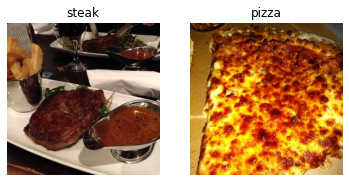

In [48]:
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
steak_img = view_random_image("pizza_steak/train/", "pizza")

In [49]:
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagenerator = ImageDataGenerator(rescale=1/255.)
test_datagenerator = ImageDataGenerator(rescale=1/255.)

In [58]:
train_data = train_datagenerator.flow_from_directory(
    directory = train_dir,
    target_size = (224, 224),
    class_mode = "binary",
    batch_size = 32
)

test_data = test_datagenerator.flow_from_directory(
    directory = test_dir,
    target_size = (224, 224),
    class_mode = "binary",
    batch_size = 32
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [59]:
images, labels = train_data.next()
len(images), len(labels)

(32, 32)

In [60]:
images[:2], images[0].shape

(array([[[[0.7019608 , 0.7294118 , 0.7686275 ],
          [0.7019608 , 0.7294118 , 0.7686275 ],
          [0.7137255 , 0.7411765 , 0.7803922 ],
          ...,
          [0.7960785 , 0.627451  , 0.49411768],
          [0.68235296, 0.5058824 , 0.37647063],
          [0.76470596, 0.5803922 , 0.46274513]],
 
         [[0.7019608 , 0.7294118 , 0.7607844 ],
          [0.7176471 , 0.74509805, 0.77647066],
          [0.7137255 , 0.7411765 , 0.7725491 ],
          ...,
          [0.7176471 , 0.54509807, 0.3921569 ],
          [0.7019608 , 0.5254902 , 0.37254903],
          [0.7058824 , 0.5176471 , 0.36078432]],
 
         [[0.654902  , 0.68235296, 0.7137255 ],
          [0.70980394, 0.7372549 , 0.7686275 ],
          [0.7058824 , 0.73333335, 0.76470596],
          ...,
          [0.7137255 , 0.5411765 , 0.35686275],
          [0.69411767, 0.5058824 , 0.31764707],
          [0.76470596, 0.5764706 , 0.38431376]],
 
         ...,
 
         [[0.37254903, 0.16470589, 0.10980393],
          [0.40784

In [61]:
labels

array([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

In [62]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [63]:
model_4 = Sequential([
    Conv2D(
        filters = 10,
        kernel_size = 3,
        strides = 1,
        padding = "valid",
        activation = "relu",
        input_shape = (224, 224, 3)
    ),
    Conv2D(10, 3, activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    Flatten(),
    Dense(1, activation = "sigmoid")
])

In [64]:

model_4.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [65]:
len(train_data), len(test_data)

(47, 16)

In [66]:
history_4 = model_4.fit(
    train_data,
    epochs = 5,
    validation_data = test_data
)

Epoch 1/5
47/47 [==============================] - 33s 706ms/step - loss: 1.6739 - accuracy: 0.6227 - val_loss: 0.5143 - val_accuracy: 0.7420
Epoch 2/5
47/47 [==============================] - 37s 783ms/step - loss: 0.4341 - accuracy: 0.8140 - val_loss: 0.4133 - val_accuracy: 0.8220
Epoch 3/5
47/47 [==============================] - 39s 826ms/step - loss: 0.2820 - accuracy: 0.9053 - val_loss: 0.3949 - val_accuracy: 0.8280
Epoch 4/5
47/47 [==============================] - 35s 749ms/step - loss: 0.1385 - accuracy: 0.9547 - val_loss: 0.5300 - val_accuracy: 0.7680
Epoch 5/5
47/47 [==============================] - 37s 782ms/step - loss: 0.0760 - accuracy: 0.9833 - val_loss: 0.5397 - val_accuracy: 0.7620


<AxesSubplot:>

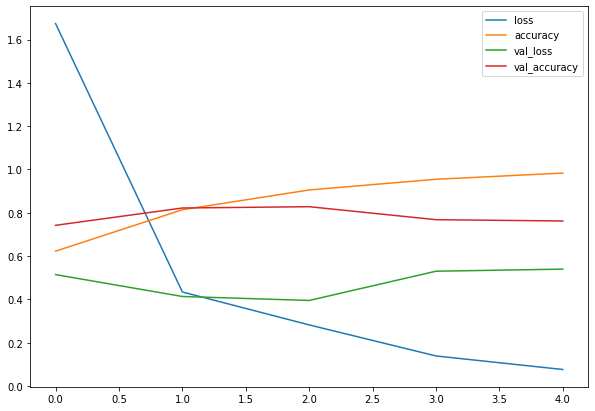

In [67]:
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize = (10, 7))

## overfitting이 된 상태!!!
## validation loss가 증가하기 시작하면, 학습 데이터를 overfitting이 되어가고 있다
## 즉, 너무나도 학습 데이터의 패턴을 잘 학습하기는 했다. 그런데 잘 모르는 데이터에 대해서 대응 잘 못한다.

In [73]:
def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="traning_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="traning_accuracy")
    plt.plot(epochs, val_accuracy, label="val_val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()    


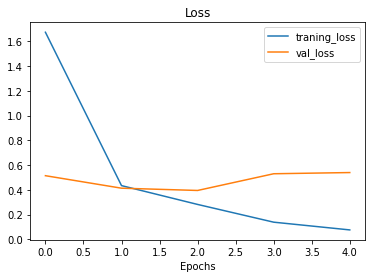

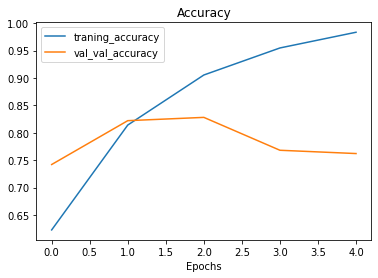

In [74]:
plot_loss_curves(history_4)

In [75]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 475240)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


In [76]:
model_5 = Sequential([
    Conv2D(
        filters = 10,
        kernel_size = 3,
        strides = 1,
        padding = "valid",
        activation = "relu",
        input_shape = (224, 224, 3)
    ),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation = "sigmoid")
])

In [77]:
model_5.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [78]:
history_5 = model_5.fit(
    train_data,
    epochs = 5,
    validation_data = test_data
)

Epoch 1/5
47/47 [==============================] - 14s 289ms/step - loss: 0.6277 - accuracy: 0.6613 - val_loss: 0.4649 - val_accuracy: 0.7980
Epoch 2/5
47/47 [==============================] - 14s 288ms/step - loss: 0.4739 - accuracy: 0.7753 - val_loss: 0.4512 - val_accuracy: 0.7920
Epoch 3/5
47/47 [==============================] - 14s 303ms/step - loss: 0.4476 - accuracy: 0.8060 - val_loss: 0.3907 - val_accuracy: 0.8500
Epoch 4/5
47/47 [==============================] - 15s 308ms/step - loss: 0.4048 - accuracy: 0.8280 - val_loss: 0.4129 - val_accuracy: 0.8180
Epoch 5/5
47/47 [==============================] - 15s 309ms/step - loss: 0.3934 - accuracy: 0.8320 - val_loss: 0.3643 - val_accuracy: 0.8380


In [79]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6760)             

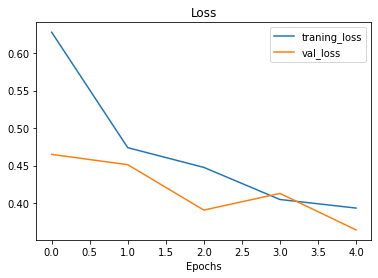

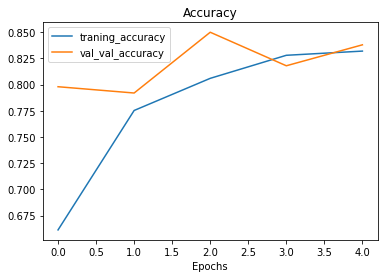

In [80]:
plot_loss_curves(history_5)

## Convolutional Neural Network의 특징 -> 가능한 이미지에서 중요한 특징, 즉 패턴을 찾겠다!!!
## MaxPooling2D의 특징 -> 가장 중요한 패턴 찾았어? 그럼 나는 쓸모없는 것 제거해 줄게!
## pool_size가 (2, 2) -> 2행 2열짜리 즉, 한번에 4개 데이터를 가지고 1개만 선택
## pool_size가 (5, 5) -> 5행 5열짜리 즉, 한번에 25개 데이터를 가지고 1개만 선택
